<a href="https://colab.research.google.com/github/cris-her/Crypto/blob/master/Temporal_Fusion_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data

In [1]:
import pandas as pd
import datetime
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import adfuller
import numpy as np
import time

import random

import plotly.graph_objects as go

header = {'open time' : 1, 'open' : 2, 'high' : 3, 'low' : 4, 'close' : 5}

#load_data from file
def load_data(year, symbol, con_cols, interval = "1m", normalise = True):
    if(type(year) != type([])):
        year = [year]
    
    if(type(symbol) != type([])):
        symbol = [symbol]
    
    frames = []
    for y in year:
        for s in symbol:
            data = pd.read_csv("data_{}/{}_{}.csv".format(interval, y, s))
            frames.append(data)    
            
    data_ = pd.concat(frames)
    
    print("done")
    #convert timestamp into month and day numbers
    data_['Hour'] = pd.to_datetime(data_["Open Time"], unit='ms').apply(lambda x: x.hour)    
    data_['Day'] = pd.to_datetime(data_["Open Time"], unit='ms').apply(lambda x: x.day - 1)
    data_['Month'] = pd.to_datetime(data_["Open Time"], unit='ms').apply(lambda x: x.month - 1)
    return data_

class Indexer():
    def __init__(self, r_bottom, r_top, batch_size, random = True, increment = 1):
        self.r_bottom = r_bottom
        self.r_top = r_top
        self.random = random
        self.increment = increment
        self.batch_size = batch_size
        self.indices = [0]
        self.next()
        
    def next(self):
        if(self.random):
            new_indices = []
            for b in range(self.batch_size):
                new_indices.append(random.randrange(self.r_bottom, self.r_top))
            self.indices = new_indices
        else:
            new_indices = [self.indices[-1]]
            
            for b in range(1, self.batch_size):
                i = new_indices[-1] + self.increment
                if(i >= self.r_top):
                    new_indices.append((i - self.top) + self.r_bottom)
                else:
                    new_indices.append(i)
            self.indices = new_indices
            
        return self.indices
    
def get_batches(data_, in_seq_len, out_seq_len, con_cols, disc_cols, target_cols, batch_size = 1, gpu = True, normalise = True, indexer = None, norm = None):
    data = data_.copy()
    
    given_indexer = True
    if indexer is None:
        given_indexer = False
        indexer = Indexer(1, data.shape[0] - (in_seq_len + out_seq_len + 1), batch_size)
        
    if normalise:
        if norm is None:
            norm = data
        data[con_cols] = (data[con_cols] - norm[con_cols].stack().mean()) / norm[con_cols].stack().std()
    
    #convert columns indices from dataframe to numpy darray
    con_cols = [data.columns.get_loc(x) for x in con_cols]
    disc_cols = [data.columns.get_loc(x) for x in disc_cols]
    target_cols = [data.columns.get_loc(x) for x in target_cols]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
        
    while True:
        #get batches
        n = np.array([pd.np.r_[i:(i + in_seq_len + out_seq_len)] for i in indexer.indices])
        batch_data = data.iloc[n.flatten()].values
        batch_data = torch.tensor(batch_data.reshape(batch_size ,in_seq_len + out_seq_len, data.shape[-1]))
        
        #split up batch data
        in_seq_continuous = batch_data[:,0:in_seq_len, con_cols]
        in_seq_discrete = batch_data[:,0:in_seq_len, disc_cols]

        out_seq= batch_data[:,in_seq_len:in_seq_len + out_seq_len, disc_cols]
        target_seq = batch_data[:,in_seq_len:in_seq_len + out_seq_len, target_cols]
    
        yield (torch.tensor(in_seq_continuous).type(dtype).unsqueeze(-1),
                        torch.tensor(in_seq_discrete).type(dtype),
                        torch.tensor(out_seq).type(dtype),
                        torch.tensor(target_seq).type(dtype))
        
        if(not given_indexer):
            indexer.next()
    
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
        
    for i in range(0, x.shape[-1]):
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Utils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

def a_norm(Q, K):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    return torch.softmax(m , -1)

def attention(Q, K, V):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K) #(batch_size, dim_attn, seq_length)
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val)
        self.key = Key(dim_val, dim_attn)
        self.query = Query(dim_val, dim_attn)
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))

#from data import one_hot
def forward_pass(model, data_gen, batch_size, quantiles, gpu = True):
    model.reset(batch_size, gpu = gpu)
    
    #Get input and target data, one-hot encode discrete variables, continuous variables have already been normalized
    in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq  = next(data_gen)
    in_seq_discrete = one_hot(in_seq_discrete, [24, 31, 12])
    future_in_seq_discrete = one_hot(future_in_seq_discrete, [24, 31, 12])
    
    #forward pass
    net_out, vs_weights = model(in_seq_continuous, in_seq_discrete, None,  future_in_seq_discrete)
    loss = torch.mean(QuantileLoss(net_out, target_seq ,quantiles))
    
    
    return loss, net_out, vs_weights, (in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq)

Download data

In [3]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd
import dateutil.parser as dp
from datetime import datetime
from datetime import timedelta  
import time
from datetime import timezone
session = Session()
import os


#converts pyton datatime to unix milisecond timestamp utc timezone
def to_utcunix(x):
    return int(x.replace(tzinfo=timezone.utc).timestamp()) * 1000

#Generator for binance price data
def get_data(start, batch_size, end = datetime.now(), symbol = "BTCUSDT", interval = "1m"):
    batch_start = start
    
    while True:
        batch_end = batch_start + timedelta(minutes = batch_size)
        
        if(batch_end > end):
            batch_end = end - timedelta(minutes = 1)
        
            if(batch_start >= end- timedelta(minutes = 1)):
                break
        
        base = "https://api.binance.com/api/v3"

        print(batch_start, batch_end)
        
        url = base + "/klines?symbol={}&interval={}&startTime={}&endTime={}&limit={}".format(symbol, interval,
                                                                                     to_utcunix(batch_start)
                                                                                    , to_utcunix(batch_end), batch_size)
        
        data = session.get(url).json()
        batch_start = batch_end
        
        #sleep to stay under binance maximum call rate
        time.sleep(0.15)
        
        #print(data)
        yield pd.DataFrame.from_dict(data)[[0,1,2,3,4,5]]

#save binance price data as csv
def gen_csv(start, filename, end = datetime.now(), symbol = "BTCUSDT", interval = "1m"):
    batch_size = 1000
    d = get_data(start, batch_size, end = end, symbol = symbol, interval = interval)
        
    try:
        os.mkdir("data_" + interval)
    except:
        pass
    
    fn = "data_" + interval + "/" + filename + ".csv"
    pd.DataFrame([["Open Time", "Open", "High",  "Low",  "Close",  "Volume"]]).to_csv(fn, mode = 'a', header = None)
    for i in d:
        i.to_csv(fn, mode = 'a', header = None)#, header = ["Open Time", "Open", "High",  "Low",  "Close",  "Volume"])

#simplified gen_csv function
def gen_csv_year(year, symbol, interval = "1m"):
    gen_csv(datetime(year,1,1) , "{}_{}".format(year, symbol) ,datetime(year + 1,1,1), symbol, interval )
    

#for i in range(2016, 2021):
#    gen_csv_year(i, "ETHUSDT")

In [4]:
gen_csv_year(2020, "ETHUSDT", interval = "5m")

2020-01-01 00:00:00 2020-01-01 16:40:00
2020-01-01 16:40:00 2020-01-02 09:20:00
2020-01-02 09:20:00 2020-01-03 02:00:00
2020-01-03 02:00:00 2020-01-03 18:40:00
2020-01-03 18:40:00 2020-01-04 11:20:00
2020-01-04 11:20:00 2020-01-05 04:00:00
2020-01-05 04:00:00 2020-01-05 20:40:00
2020-01-05 20:40:00 2020-01-06 13:20:00
2020-01-06 13:20:00 2020-01-07 06:00:00
2020-01-07 06:00:00 2020-01-07 22:40:00
2020-01-07 22:40:00 2020-01-08 15:20:00
2020-01-08 15:20:00 2020-01-09 08:00:00
2020-01-09 08:00:00 2020-01-10 00:40:00
2020-01-10 00:40:00 2020-01-10 17:20:00
2020-01-10 17:20:00 2020-01-11 10:00:00
2020-01-11 10:00:00 2020-01-12 02:40:00
2020-01-12 02:40:00 2020-01-12 19:20:00
2020-01-12 19:20:00 2020-01-13 12:00:00
2020-01-13 12:00:00 2020-01-14 04:40:00
2020-01-14 04:40:00 2020-01-14 21:20:00
2020-01-14 21:20:00 2020-01-15 14:00:00
2020-01-15 14:00:00 2020-01-16 06:40:00
2020-01-16 06:40:00 2020-01-16 23:20:00
2020-01-16 23:20:00 2020-01-17 16:00:00
2020-01-17 16:00:00 2020-01-18 08:40:00


In [12]:
gen_csv_year(2018, "BTCUSDT", interval = "5m")

2018-01-01 00:00:00 2018-01-01 16:40:00
2018-01-01 16:40:00 2018-01-02 09:20:00
2018-01-02 09:20:00 2018-01-03 02:00:00
2018-01-03 02:00:00 2018-01-03 18:40:00
2018-01-03 18:40:00 2018-01-04 11:20:00
2018-01-04 11:20:00 2018-01-05 04:00:00
2018-01-05 04:00:00 2018-01-05 20:40:00
2018-01-05 20:40:00 2018-01-06 13:20:00
2018-01-06 13:20:00 2018-01-07 06:00:00
2018-01-07 06:00:00 2018-01-07 22:40:00
2018-01-07 22:40:00 2018-01-08 15:20:00
2018-01-08 15:20:00 2018-01-09 08:00:00
2018-01-09 08:00:00 2018-01-10 00:40:00
2018-01-10 00:40:00 2018-01-10 17:20:00
2018-01-10 17:20:00 2018-01-11 10:00:00
2018-01-11 10:00:00 2018-01-12 02:40:00
2018-01-12 02:40:00 2018-01-12 19:20:00
2018-01-12 19:20:00 2018-01-13 12:00:00
2018-01-13 12:00:00 2018-01-14 04:40:00
2018-01-14 04:40:00 2018-01-14 21:20:00
2018-01-14 21:20:00 2018-01-15 14:00:00
2018-01-15 14:00:00 2018-01-16 06:40:00
2018-01-16 06:40:00 2018-01-16 23:20:00
2018-01-16 23:20:00 2018-01-17 16:00:00
2018-01-17 16:00:00 2018-01-18 08:40:00


KeyError: ignored

Load data

In [13]:
%load_ext autoreload
%autoreload 2


from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)         # initiate notebook for offline plot
import plotly.express as px
from scipy import stats
#from data import *

continuous_columns = ['Open', 'High', 'Low', 'Close']
discrete_columns = ['Hour']#, 'Day', 'Month']
target_columns = ['Close']

data = load_data('2019', 'BTCUSDT',continuous_columns, interval = '5m') #2018

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


done


In [14]:
#continuous_columns = ['Open', 'High', 'Low', 'Close']
#discrete_columns = ['Hour']#, 'Day', 'Month']
#target_columns = ['Close']
g = get_batches(data,1000, 1, continuous_columns, discrete_columns, 
                target_columns, batch_size = 1, gpu = False, normalise = False)

in_seq_continuous, in_seq_discrete, out_seq, target_seq  = next(g)
c = in_seq_continuous[:,:,0].squeeze()

c = pd.DataFrame(c)[0]
#print(adfuller(c)[1])
#print(c)
c = pd.DataFrame(stats.boxcox(c)[0])[0]

c = c.pct_change()

#c =(c - c.mean()) / c.std() 


c = c.cumsum()
c = c.drop(c.index[0])

print(adfuller(c)[1])
#print(c[0])

#c = stats.boxcox(c)[0]
fig = px.line(c)
fig.show()
#print(in_seq_discrete.scatter_(1, in_seq_discrete.long(), 1))


#print("Dickey–Fuller test {}".format())

#print(in_seq_discrete)
#print(in_seq_continuous[:,0])
fig = go.Figure(data=[go.Candlestick(open=in_seq_continuous[:,:,0].squeeze(),
                high=in_seq_continuous[:,:,1].squeeze(),
                low=in_seq_continuous[:,:,2].squeeze(),
                close=in_seq_continuous[:,:,3].squeeze())])


fig2 = px.line(target_seq)

fig.show()
#fig2.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/loc

nan


In [15]:
interval = '1h'
y = '2017'
symbol = 'BTCUSDT'

d = pd.read_csv("data_{}/{}_{}.csv".format(interval, y, symbol), header = None)

d = d[[1,2,3,4,5,6]]
d = d.rename(columns = {1 : "Open Time", 2 : "Open", 3 : "High", 4 : "Low", 5 : "Close", 6 : "Volume"})

FileNotFoundError: ignored

In [ ]:
d

Network

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
#from utils import *

class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x)
    
class GRN(torch.nn.Module):
    def __init__(self, dim_input, dim_out = None, n_hidden = 10, dropout_r = 0.1):
        super(GRN, self).__init__()
        
        if(dim_out != None):
            self.skip = nn.Linear(dim_input, dim_out)
        else:
            self.skip = None
            dim_out = dim_input
        
        self.fc1 = nn.Linear(dim_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, dim_out)
        self.dropout = nn.Dropout(dropout_r)
        
        self.gate = GLU(dim_out)
        
        self.norm = nn.LayerNorm(dim_out)
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        
        a = self.gate(a)
        
        if(self.skip != None):
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)

class VSN(torch.nn.Module):
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r = 0.1):
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        
        
        #Linear transformation of inputs into dmodel vector
        self.linearise = []
        for i in range(n_var_cont):
            self.linearise.append(nn.Linear(1, dim_model, bias = False).cuda())
        self.fc = nn.Linear(1, dim_model, bias = False).cuda()
        
        #entity embedings for discrete inputs
        self.entity_embed = []
        for i in n_var_disc:
            self.entity_embed.append(nn.Linear(i, dim_model, bias = False).cuda())
        
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r)
        self.vs_grn = GRN(n_var_total * dim_model, dim_out = n_var_total, dropout_r = dropout_r)
    
    #takes input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc):
        #linearise continuous inputs
        linearised = []
        for idx, fc in enumerate(self.linearise):
            linearised.append(fc(x_cont[:,:,idx]))
        
        #entity embeddings for discrete inputs
        embedded = []
        for x, fc in zip(x_disc, self.entity_embed):
            embedded.append(fc(x))
        
        if(len(self.linearise) != 0 and len(self.entity_embed) != 0):
            linearised = torch.stack(linearised, dim = -2)
            embedded = torch.stack(embedded, dim = -2)
            vectorised_vars = torch.cat((linearised, embedded), dim = -2) #(batch_size, seq_len, dim_model, n_vars_total)
        elif(len(self.linearise) != 0 and len(self.entity_embed) == 0):
            vectorised_vars = torch.stack(linearised, dim = -2) #(batch_size, seq_len, n_var_cont, dim_model)
        elif(len(self.entity_embed) != 0 and len(self.linearise) == 0):
            vectorised_vars = torch.stack(embedded, dim = -2)#(batch_size, seq_len, n_var_disc, dim_model)
        
        #flatten everything except accross batch for variable selection weights
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim = 2)) #(batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim = -1).unsqueeze(-1) #(batch_size, seq_len, n_variables, 1)
        
        #input_grn applied to every input seperatly
        input_weights = self.input_grn(vectorised_vars) #(batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2)
        return x, vs_weights #returns(batch_size, seq_len, dim_model)

    
class LSTMLayer(torch.nn.Module):
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers
        self.dim_model = dim_model
        
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True)
        self.hidden = None
        
        self.dropout = nn.Dropout(dropout_r)
    
    #takes input (batch_size, seq_len, dim_model)
    def forward(self, x):
        if(self.hidden == None):
            raise Exception("Call reset() to initialise LSTM Layer")
            
            
        x, self.hidden = self.lstm(x, self.hidden)
        x = self.dropout(x)
        
        return x, self.hidden #returns (batch_size, seq_len, dim_model), hidden
    
    def reset(self, batch_size, gpu = True):
        if(not gpu):
            dtype = torch.FloatTensor
        else:
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                   torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype))
        
class TFN(torch.nn.Module):
    def __init__(self, n_var_past_cont, n_var_future_cont, n_var_past_disc, n_var_future_disc
                 , dim_model, n_quantiles = 3, dropout_r = 0.1, n_lstm_layers = 1, n_attention_layers = 1, n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r)
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers)
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers)
        
        self.gate1 = GLU(dim_model)
        self.norm1 = nn.LayerNorm(dim_model)
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = []
        for i in range(n_attention_layers):
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()])
            
        self.norm2 = nn.LayerNorm(dim_model)
        
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r)
        self.norm3 = nn.LayerNorm(dim_model)
        
        self.dropout = nn.Dropout(dropout_r)
        self.fc_out = nn.Linear(dim_model, n_quantiles)
        
    #takes input (batch_size, past_seq_len, n_variables_past)
    #, (batch_size, future_seq_len, n_variables_future)
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        #Encoder
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc)
        
        e, e_hidden = self.enc(x_past)
        self.dec.hidden = e_hidden
        
        e = self.dropout(e)
        x_past = self.norm1(self.gate1(e) + x_past)
        
        #Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc)
        
        d, _ = self.dec(x_future)
        d = self.dropout(d)
        x_future = self.norm1(self.gate1(d) + x_future)
        
        #Static enrichment
        x = torch.cat((x_past, x_future), dim = 1) #(batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x)
        
        #attention layer
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a)
        
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future)
        
        a = self.positionwise_grn(x_future)
        x_future = self.norm3(a + x_future + attention_res)
        
        net_out = self.fc_out(x_future)
        return net_out, vs_weights
    
    def reset(self, batch_size, gpu = True):
        self.enc.reset(batch_size, gpu)
        self.dec.reset(batch_size, gpu)  

Implementation

In [20]:
!pip install --upgrade mplfinance

     |████████████████████████████████| 62 kB 930 kB/s 


In [23]:
import torch
import torch.nn as nn
#from network import *
#from data import *
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math
from mplfinance.original_flavor import candlestick_ohlc

In [24]:
continuous_columns = ['Open', 'High', 'Low', 'Close']
discrete_columns = ['Hour']#, 'Day', 'Month']
target_columns = ['Close']

In [26]:
print("Loading : ")
btc_data = load_data(['2019'], 'BTCUSDT', continuous_columns, '5m') #'2018', 
btc_test_data = load_data(['2020'], 'BTCUSDT', continuous_columns, interval = '5m')

Loading : 
done
done


In [27]:
#input data shape
n_variables_past_continuous = 4
n_variables_future_continuous = 0
n_variables_past_discrete = [24]#, 31, 12]
n_variables_future_discrete = [24]#, 31, 12]

#hyperparams
batch_size = 160
test_batch_size = 160
n_tests = 25
dim_model = 160
n_lstm_layers = 4
n_attention_layers = 3
n_heads = 6

quantiles = torch.tensor([0.1, 0.5, 0.9]).float().type(torch.cuda.FloatTensor)

past_seq_len = 80
future_seq_len = 15

In [29]:
load_model = False
path = "model_100000.pt"

#initialise
t = TFN(n_variables_past_continuous, n_variables_future_continuous, 
            n_variables_past_discrete, n_variables_future_discrete, dim_model,
            n_quantiles = quantiles.shape[0], dropout_r = 0.2,
            n_attention_layers = n_attention_layers,n_lstm_layers = n_lstm_layers, n_heads = n_heads).cuda()
optimizer = torch.optim.Adam(t.parameters(), lr=0.0005)

#try to load from checkpoint
if load_model:
    checkpoint = torch.load(path)
    t = checkpoint['model_state']
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    losses = checkpoint['losses']
    test_losses = checkpoint['test_losses']
    print("Loaded model from checkpoint")
else:    
    losses = []
    test_losses = []
    print("No checkpoint loaded, initialising model")


#losses = []

No checkpoint loaded, initialising model


In [30]:
btc_gen = get_batches(btc_data, past_seq_len, 
                future_seq_len, continuous_columns, discrete_columns, 
                target_columns, batch_size = batch_size)

test_btc_gen = get_batches(btc_test_data, past_seq_len, 
            future_seq_len, continuous_columns, discrete_columns, 
            target_columns, batch_size = batch_size, norm = btc_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/loc

RuntimeError: ignored

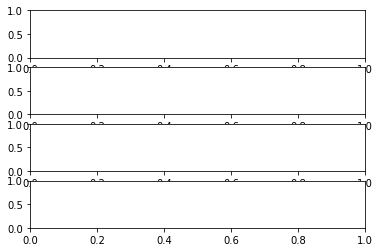

In [36]:
fig = plt.figure()
ax = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)
plt.ion()


fig.canvas.draw()
fig.show()

steps = 200000
for e in range(steps):
    #run model against test set every 50 batches
    if(e % 50 == 0):
        
        t.eval()
        m_test_losses = []
        for i in range(n_tests):
            test_loss,_ , _, _ = forward_pass(t, test_btc_gen, test_batch_size, quantiles)
            m_test_losses.append(test_loss.cpu().detach().numpy())
            t.train()
        
        test_losses.append(np.array(m_test_losses).mean())
        
    #save model every 400 batches
    if(e % 400 == 0):
        torch.save({'model_state' : t,
                    'optimizer_state': optimizer.state_dict(),
                   'losses' : losses, 'test_losses' : test_losses} , "model_{}.pt".format(len(losses)))
        
    #forward pass
    optimizer.zero_grad()
    loss, net_out, vs_weights, given_data = forward_pass(t, btc_gen, batch_size, quantiles)
    net_out = net_out.cpu().detach()[0]
    
    #backwards pass
    losses.append(loss.cpu().detach().numpy())
    loss.backward()
    optimizer.step()
    
    #loss graphs
    fig.tight_layout(pad = 0.1)
    ax.clear()
    ax.title.set_text("Training loss")
    ax.plot(losses[250:])
    
    ax1.clear()
    ax1.title.set_text("Test loss")
    ax1.plot(test_losses[5:]) 
    
    #compare network out put and data
    ax2.clear()
    ax2.title.set_text("Network output comparison")
    c = given_data[0][0].cpu()
    a = torch.arange(-past_seq_len, 0).unsqueeze(-1).unsqueeze(-1).float()
    c = torch.cat((a,c), dim = 1)
    candlestick_ohlc(ax2, c.squeeze(), colorup = "green", colordown = "red")

    ax2.plot(net_out[:,0], color = "red")
    ax2.plot(net_out[:,1], color = "blue")
    ax2.plot(net_out[:,2], color = "red")
    ax2.plot(given_data[3].cpu().detach().numpy()[0], label = "target", color = "orange")

    #visualise variable selection weights
    vs_weights = torch.mean(torch.mean(vs_weights, dim = 0), dim = 0).squeeze()
    vs_weights = vs_weights.cpu().detach().numpy()
    ax3.clear()
    ax3.title.set_text("Variable Selection Weights")
    plt.xticks(rotation=-30)
    x = ['Open', 'High', 'Low', 'Close', 'Hour']
    ax3.bar(x = x, height = vs_weights)
    fig.canvas.draw()
    
    del loss
    del net_out
    del vs_weights
    del given_data
    if e >= 2:
        break


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/loc

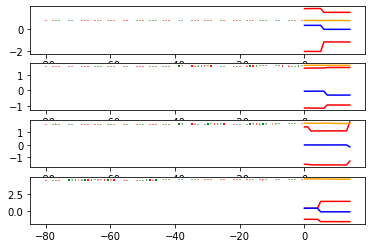

In [37]:
%matplotlib inline
#%matplotlib notebook
#Draw test cases
fig = plt.figure()
axes = []
batch_size_ = 4

for i in range(batch_size_):
    axes.append(fig.add_subplot(411 + i))
    
test_btc_gen = get_batches(btc_test_data, past_seq_len, 
            future_seq_len, continuous_columns, discrete_columns, 
            target_columns, batch_size = batch_size_, norm = btc_data)

loss, net_out, vs_weights, given_data = forward_pass(t, test_btc_gen, batch_size_, quantiles)
net_out = net_out.cpu().detach()
t.eval()
for idx, a in enumerate(axes):
    a.clear()
    
    c = given_data[0][idx].cpu()
    
    b = torch.arange(-past_seq_len, 0).unsqueeze(-1).unsqueeze(-1).float()
    c = torch.cat((b,c), dim = 1)
    candlestick_ohlc(a, c.squeeze(), colorup = "green", colordown = "red")
    
    
    
    a.plot(net_out[idx][:,0], color = "red")
    a.plot(net_out[idx][:,1], color = "blue")
    a.plot(net_out[idx][:,2], color = "red")
    a.plot(given_data[3].cpu().detach().numpy()[idx], label = "target", color = "orange")

t.train()    
plt.ion()

fig.show()
fig.canvas.draw()